In [2]:
%matplotlib inline
import histories
import mushi
import msprime
import stdpopsim
import composition as cmp
from IPython.display import display, SVG
import numpy as np
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
from scipy.special import expit
import time

In [3]:
# Change points is a one-dimensional array with length 100, min=10^0, max=10^5
# np.log10(100000) = 5
change_points = np.logspace(0, np.log10(100000), 100)
# Insert an additional 0 to the front of the array
t = np.concatenate((np.array([0]), change_points))

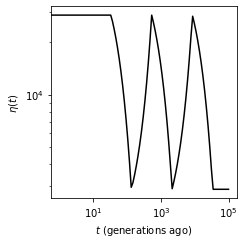

In [4]:
species = stdpopsim.get_species("HomSap")
model = species.get_demographic_model("Zigzag_1S14")
ddb = model.get_demography_debugger()
eta_true = histories.eta(change_points, 2 * ddb.population_size_trajectory(steps=t)[:, 0])

plt.figure(figsize=(3.5, 3.5))
eta_true.plot(c='k')
plt.show()

/home/lukezhu/anaconda3/envs/mushi/lib/python3.7/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


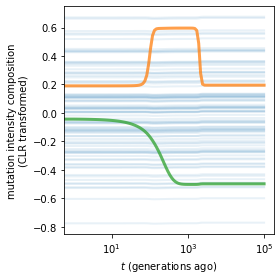

In [5]:
flat = np.ones_like(t)
pulse = expit(.1 * (t - 100)) - expit(.01 * (t - 2000))
ramp = expit(-.01 * (t - 100)) 
n_mutation_types = 96
Z = np.zeros((len(t), n_mutation_types))
mu0 = 1
np.random.seed(0)

Z[:, 0] = mu0 * (1 * flat + .5 * pulse)

Z[:, 1] = mu0 * (.5 * flat + .4 * ramp)

for col in range(2, n_mutation_types):
    scale = np.random.lognormal(-.2, .3)
    pulse_weight = 5 if col == 0 else 0
    Z[:, col] = mu0 * scale * flat

# change_points = epoch change times
mu_true = histories.mu(change_points, Z)

plt.figure(figsize=(4, 4))
mu_true.plot(range(2, n_mutation_types), alpha=0.1, lw=2, c='C0', clr=True)
mu_true.plot((0,), alpha=0.75, lw=3, c='C1', clr=True)
mu_true.plot((1,), alpha=0.75, lw=3, c='C2', clr=True)
plt.show()

In [6]:
mu0 = mu_true.Z[0, :].sum()
print(mu0)

83.11894862750988


In [7]:
n = 200
chrom = 1
species = stdpopsim.get_species('HomSap')
contig = species.get_contig(f'chr{chrom}')
contig = stdpopsim.Contig(recombination_map=contig.recombination_map, mutation_rate=0, genetic_map=contig.genetic_map)
# For PieceWiseConstantSize, first argument is the initial pop size, and each subsequent argument is a tuple (t, N) which gives the time at which the size change takes place and the population size.
# Not sure why Will divided the number by 2
model = stdpopsim.PiecewiseConstantSize(eta_true.y[0] / 2, *zip(change_points, eta_true.y[1:] / 2))
# Returns a list of msprime.Sample objects
samples = model.get_samples(n)
engine = stdpopsim.get_default_engine()
ts = engine.simulate(model, contig, samples, mutation_rate=0)

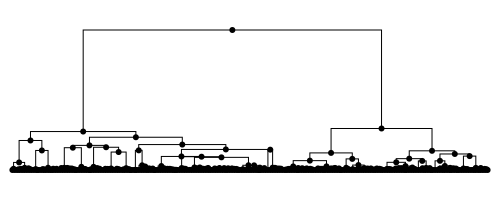

In [8]:
display(SVG(ts.first().draw(format='svg', width=500, height=200, node_labels={},
                                       mutation_labels={})))

96


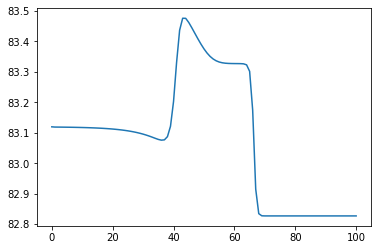

In [9]:
Z_tot = Z.sum(axis=1)
Z_tot.shape
print(Z.shape[1])
plt.figure()
plt.plot(Z_tot)

mu_tot_true = histories.mu(change_points, Z_tot)
# help(histories.mu)
# mu_true.mutation_types

In [ ]:
X = np.zeros((n - 1, n_mutation_types))

ts_j = ts
mutation_rate_arr = []
for start_time, end_time, mutation_rate in mu_tot_true.epochs():
    mutation_rate_arr.append(mutation_rate) 
    print(f'epoch boundaries: ({start_time:.2f}, {end_time:.2f}), μ: {mutation_rate[0]:2f}     ', flush=False, end='     \r')
    
    # note: the factor of 1 / chrom.length is needed to scale the mutation rate from sites to genomes
    ts_j = msprime.mutate(ts_j,
                          rate=mutation_rate[0] / species.genome.chromosomes[chrom - 1].length,                                   
                          start_time=start_time,
                          end_time=end_time,
                          random_seed=1,
                          keep=True)

plt.figure()
plt.plot(mutation_rate_arr)
print(len(mutation_rate_arr))

In [10]:
# size 199 * 96, n-1 => number of sampled haplotypes, n_mutation_types = 96
X = np.zeros((n - 1, n_mutation_types))

for j in range(n_mutation_types):
    # ts_j is the tree sequence after applying mutation
    ts_j = ts
    for start_time, end_time, mutation_rate in mu_true.epochs():
        print(f'mutation type {j + 1}, epoch boundaries: ({start_time:.2f}, {end_time:.2f}), μ: {mutation_rate[j]:.2f}     ', flush=True, end='     \r')
        # note: the factor of 1 / chrom.length is needed to scale the mutation rate from sites to genomes
        ts_j = msprime.mutate(ts_j,
                              rate=mutation_rate[j] / species.genome.chromosomes[chrom - 1].length,                                   
                              start_time=start_time,
                              end_time=end_time,
                              random_seed=1,
                              keep=True)
    X[:, j] = ts_j.allele_frequency_spectrum(polarised=True, span_normalise=False)[1:-1]
print(X[:, 1])

KeyboardInterrupt: 